In [169]:
import pandas as pd 
import numpy as np 

import warnings
warnings.filterwarnings("ignore")


from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import (
    GridSearchCV, 
    RandomizedSearchCV,
    train_test_split
)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler, 
    LabelEncoder
)

import phik
from phik.report import plot_correlation_matrix
from phik import report


from matplotlib import pyplot as plt 
import seaborn as sns 
plt.style.use('dark_background')
plt.rcParams["figure.figsize"] = (15,5)

RANDOM_STATE = 42

DATA_PATH = 'autos.csv'
#DATA_PATH = '/datasets/autos.csv'

# dq 

## first check 

In [170]:
df = pd.read_csv('autos.csv')

In [171]:
df.sample(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
49426,2016-03-07 15:49:43,15000,suv,2007,auto,190,m_klasse,150000,7,gasoline,mercedes_benz,no,2016-03-07 00:00:00,0,89079,2016-03-10 05:16:17
47892,2016-03-27 18:57:59,1499,wagon,2004,manual,90,focus,150000,1,gasoline,ford,no,2016-03-27 00:00:00,0,1445,2016-03-31 01:16:09
182888,2016-03-29 00:56:53,7500,sedan,2008,auto,122,golf,150000,5,petrol,volkswagen,no,2016-03-29 00:00:00,0,41238,2016-04-07 07:45:47
243654,2016-03-21 19:39:04,250,NaN,2016,manual,0,astra,150000,5,NaN,opel,NaN,2016-03-21 00:00:00,0,89522,2016-04-02 21:18:57
198118,2016-03-26 19:45:24,3999,coupe,1999,manual,170,3er,150000,2,petrol,bmw,no,2016-03-26 00:00:00,0,10369,2016-04-06 09:17:46


In [172]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [173]:
df['LastSeen'] = df['LastSeen'].astype('datetime64')
df['DateCrawled'] = df['DateCrawled'].astype('datetime64')
df['DateCreated'] = df['DateCreated'].astype('datetime64')
df.columns = [col.lower() for col in df.columns]

## NaN's

In [174]:
round(df.isnull().mean().sort_values(ascending=False)*100,2)

repaired             20.08
vehicletype          10.58
fueltype              9.28
gearbox               5.60
model                 5.56
datecrawled           0.00
price                 0.00
registrationyear      0.00
power                 0.00
kilometer             0.00
registrationmonth     0.00
brand                 0.00
datecreated           0.00
numberofpictures      0.00
postalcode            0.00
lastseen              0.00
dtype: float64

получается, что очень много пропусков в колонках repaired, venicletype, fueltype, gearbox, model. 

местами пропусков слишком много, чтобы просто так выкинуть, но и замазать средним не получится, признаки категориальные. 

лучше просто в датасете так и прошим: неизвестно. станет отдельной категорией 

In [175]:
df['repaired'] = df['repaired'].fillna('unknown')
df['vehicletype'] = df['vehicletype'].fillna('unknown')
df['gearbox'] = df['gearbox'].fillna('unknown')
df['model'] = df['model'].fillna('unknown')

## EDA + features clean up 

In [176]:
display(df.select_dtypes(include='datetime').describe())
df.drop(df.select_dtypes(include='datetime').columns, axis = 1, inplace=True) 

,datecrawled,datecreated,lastseen
count,354369,354369,354369
unique,271174,109,179150
top,2016-03-24 14:49:47,2016-04-03 00:00:00,2016-04-06 13:45:54
freq,7,13719,17
first,2016-03-05 14:06:22,2014-03-10 00:00:00,2016-03-05 14:15:08
last,2016-04-07 14:36:58,2016-04-07 00:00:00,2016-04-07 14:58:51


в данных с датами особо нет аномалий, но выглядят они как данные о юзерах/объявлениях и на цену машины влиять не должны. 
лучше бы их удалить. 

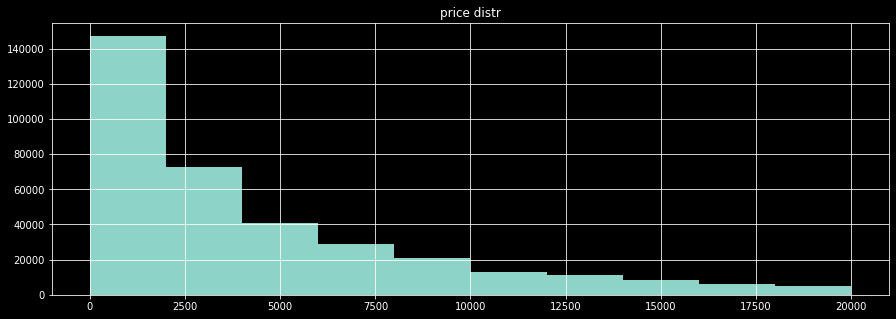

In [177]:
plt.title('price distr')
df.price.hist()
plt.show()

в целом все ок, распределение цены выглядят логичным

In [178]:
df.vehicletype.value_counts(normalize=True)

sedan          0.258084
small          0.225276
wagon          0.183893
unknown        0.105794
bus            0.081201
convertible    0.057011
coupe          0.045611
suv            0.033852
other          0.009278
Name: vehicletype, dtype: float64

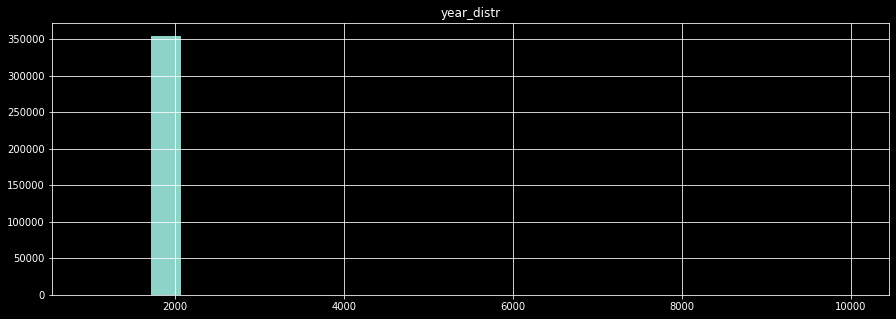

count    354369.000000
mean       2004.234448
std          90.227958
min        1000.000000
0%         1000.000000
1%         1980.000000
50%        2003.000000
90%        2012.000000
95%        2016.000000
99%        2018.000000
max        9999.000000
Name: registrationyear, dtype: float64

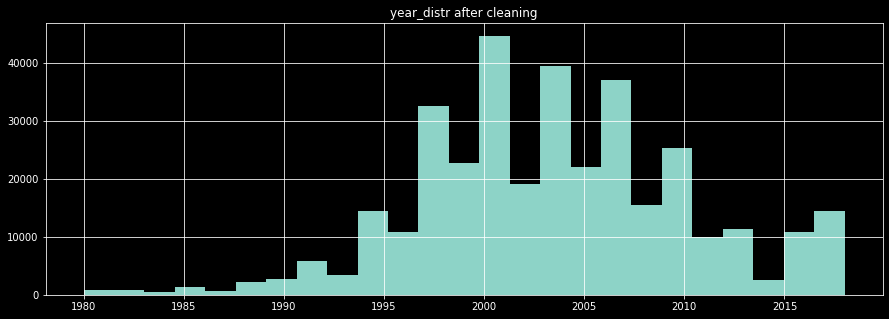

count    350787.000000
mean       2003.421911
std           6.610245
min        1980.000000
0%         1980.000000
1%         1987.000000
50%        2003.000000
90%        2012.000000
95%        2016.000000
99%        2018.000000
max        2018.000000
Name: registrationyear, dtype: float64

In [179]:
plt.title('year_distr')
df['registrationyear'].hist(bins = 25)
plt.show() 

display(df['registrationyear'].describe(percentiles=[0, 0.01, 0.5, 0.9, 0.95, 0.99]))

df = df.query('registrationyear > = 1980 and registrationyear <= 2018')

plt.title('year_distr after cleaning')
df['registrationyear'].hist(bins = 25)
plt.show() 

display(df['registrationyear'].describe(percentiles=[0, 0.01, 0.5, 0.9, 0.95, 0.99]))

есть какие-то нереально старые машины, которым практически тысяяча лет в обед. 
их, пожалуй, лучше выкинуть из выборки

In [180]:
df['gearbox'].value_counts(normalize=True)

manual     0.758777
auto       0.187088
unknown    0.054135
Name: gearbox, dtype: float64

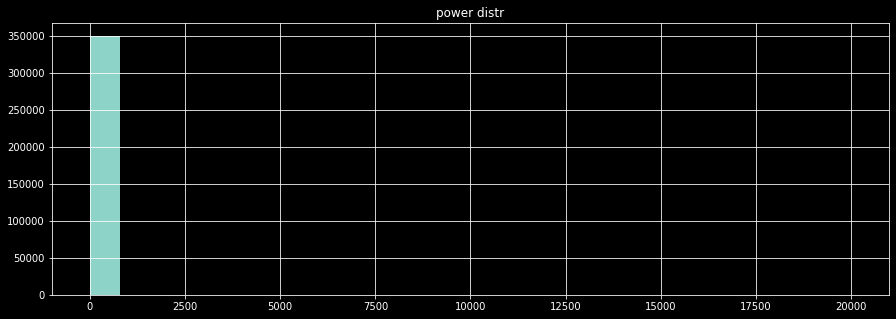

count    350787.000000
mean        110.422701
std         188.275356
min           0.000000
0%            0.000000
1%            0.000000
2%            0.000000
5%            0.000000
10%           0.000000
50%         105.000000
90%         179.000000
95%         218.000000
99%         300.000000
max       20000.000000
Name: power, dtype: float64

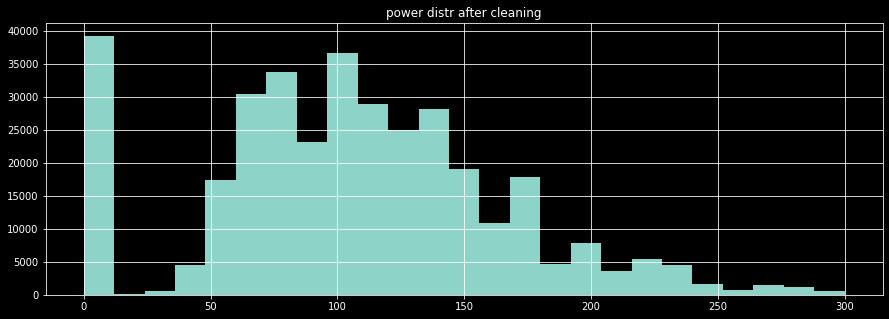

count    347354.000000
mean        104.772656
std          59.083956
min           0.000000
0%            0.000000
1%            0.000000
2%            0.000000
5%            0.000000
10%           0.000000
50%         103.000000
90%         177.000000
95%         204.000000
99%         258.000000
max         300.000000
Name: power, dtype: float64

In [181]:
plt.title('power distr')
df['power'].hist(bins = 25)
plt.show()
display(df['power'].describe(percentiles=[0, 0.01, 0.02, 0.1, 0.05,  0.5, 0.9, 0.95, 0.99]))

df = df.query('power <= 300') 

plt.title('power distr after cleaning')
df['power'].hist(bins = 25)
plt.show()
display(df['power'].describe(percentiles=[0, 0.01, 0.02, 0.1, 0.05,  0.5, 0.9, 0.95, 0.99]))


вот с мощностью тоже куча объявлений с 0, удалить не получится -- слишком много, лучше заполнить условным средним

In [182]:
df['power'] = np.where(df['power'] > 5, df['power'], df['power'] + df['power'].mean())

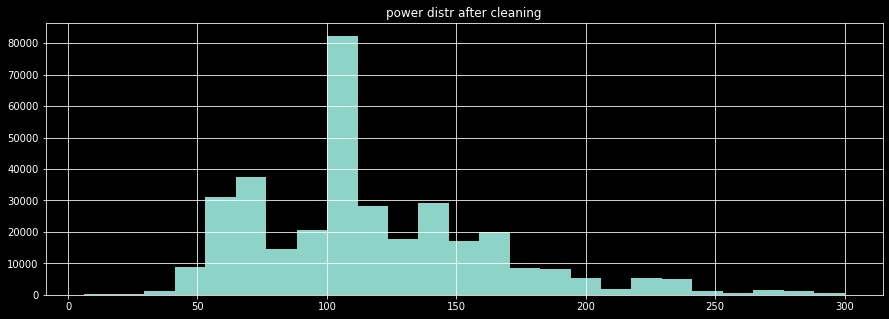

count    347354.000000
mean        116.589644
std          45.973850
min           6.000000
0%            6.000000
1%           45.000000
2%           50.000000
5%           55.000000
10%          60.000000
50%         104.772656
90%         177.000000
95%         204.000000
99%         258.000000
max         300.000000
Name: power, dtype: float64

In [183]:
plt.title('power distr after cleaning')
df['power'].hist(bins = 25)
plt.show()
display(df['power'].describe(percentiles=[0, 0.01, 0.02, 0.1, 0.05,  0.5, 0.9, 0.95, 0.99]))

In [184]:
df['model'].value_counts(normalize=True).sort_values(ascending=False)*100

golf                  8.375030
other                 6.484163
3er                   5.632582
unknown               5.315039
polo                  3.752080
                        ...   
i3                    0.002303
rangerover            0.001152
serie_2               0.000864
range_rover_evoque    0.000576
serie_3               0.000288
Name: model, Length: 250, dtype: float64

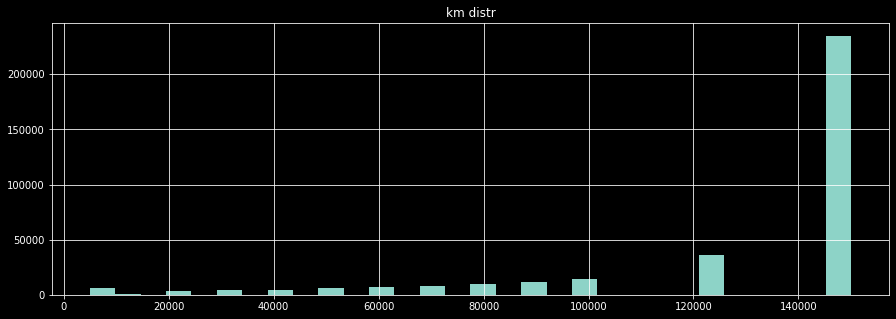

уникальных категорий километража 13


150000    0.675694
125000    0.103192
100000    0.041258
90000     0.032563
80000     0.028170
70000     0.024062
60000     0.020901
50000     0.017400
5000      0.016496
40000     0.013755
30000     0.012391
20000     0.011032
10000     0.003086
Name: kilometer, dtype: float64

In [185]:
plt.title('km distr')
df['kilometer'].hist(bins=30)
plt.show()

print('уникальных категорий километража', df['kilometer'].nunique())

df['kilometer'].value_counts(normalize='True')

интересно, что километраж выглядит скорее категориальной фичей, всего 13 уникальных значений, при этом видно, что большая часть машин с ощутимым пробегом

<AxesSubplot:>

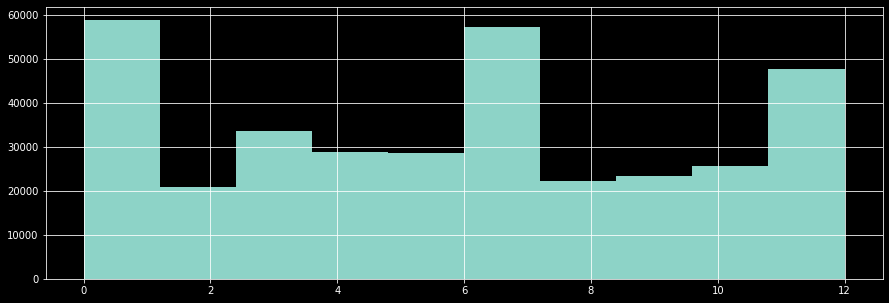

In [186]:
df['registrationmonth'].hist()

In [187]:
df['fueltype'].value_counts(normalize=True)

petrol      0.669536
gasoline    0.311310
lpg         0.015846
cng         0.001768
hybrid      0.000729
other       0.000536
electric    0.000276
Name: fueltype, dtype: float64

In [188]:
df['brand'].value_counts(normalize=True).head(10)

volkswagen       0.219131
opel             0.113668
bmw              0.103744
mercedes_benz    0.088167
audi             0.082861
ford             0.071354
renault          0.051406
peugeot          0.031550
fiat             0.027125
seat             0.019801
Name: brand, dtype: float64

In [189]:
df['repaired'].value_counts(normalize=True)

no         0.698253
unknown    0.199670
yes        0.102077
Name: repaired, dtype: float64

в данных довольно много фирм и моделей, в основном представлены дизельные и бензиновые автомобили. 

после прпоусков в repaired получилось, около 20% машин без определенного статуса по ремонту. 

In [190]:
display(df['numberofpictures'].describe())
df.drop(['numberofpictures'], axis = 1, inplace = True)

count    347354.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: numberofpictures, dtype: float64

в признаке df['numberofpictures'] только нулевые значения, его лучше удалить полностью

In [191]:
df['postalcode'].value_counts()

10115    795
65428    609
66333    341
32257    313
44145    310
        ... 
6638       1
29487      1
89368      1
95356      1
31096      1
Name: postalcode, Length: 8140, dtype: int64

с postal code все немного сложнее. с одной стороны -- это явно признак категориальный, с другой стороны парсить его на флаги невыгодно, слишком много уникальных значений. сам код может отражать город, а в разных городах цены на атвомобили могут отличаться в теории.

# feature correlation

In [192]:
phik_overview = df.phik_matrix()
phik_overview.round(2)

interval columns not set, guessing: ['price', 'registrationyear', 'power', 'kilometer', 'registrationmonth', 'postalcode']


,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,repaired,postalcode
price,1.00,0.28,0.69,0.30,0.51,0.58,0.32,0.19,0.27,0.35,0.37,0.10
vehicletype,0.28,1.00,0.55,0.51,0.48,0.89,0.24,0.20,0.33,0.58,0.45,0.07
registrationyear,0.69,0.55,1.00,0.19,0.34,0.61,0.43,0.19,0.28,0.36,0.31,0.09
gearbox,0.30,0.51,0.19,1.00,0.48,0.62,0.07,0.27,0.18,0.51,0.48,0.09
power,0.51,0.48,0.34,0.48,1.00,0.80,0.13,0.14,0.27,0.63,0.20,0.09
model,0.58,0.89,0.61,0.62,0.80,1.00,0.44,0.20,0.54,1.00,0.33,0.22
kilometer,0.32,0.24,0.43,0.07,0.13,0.44,1.00,0.06,0.15,0.27,0.23,0.04
registrationmonth,0.19,0.20,0.19,0.27,0.14,0.20,0.06,1.00,0.06,0.11,0.30,0.05
fueltype,0.27,0.33,0.28,0.18,0.27,0.54,0.15,0.06,1.00,0.33,0.06,0.05
brand,0.35,0.58,0.36,0.51,0.63,1.00,0.27,0.11,0.33,1.00,0.16,0.18


In [193]:
phik_overview['price'].sort_values(ascending = False)

price                1.000000
registrationyear     0.694443
model                0.575421
power                0.505408
repaired             0.368737
brand                0.351754
kilometer            0.319092
gearbox              0.295854
vehicletype          0.277590
fueltype             0.267931
registrationmonth    0.185336
postalcode           0.095222
Name: price, dtype: float64

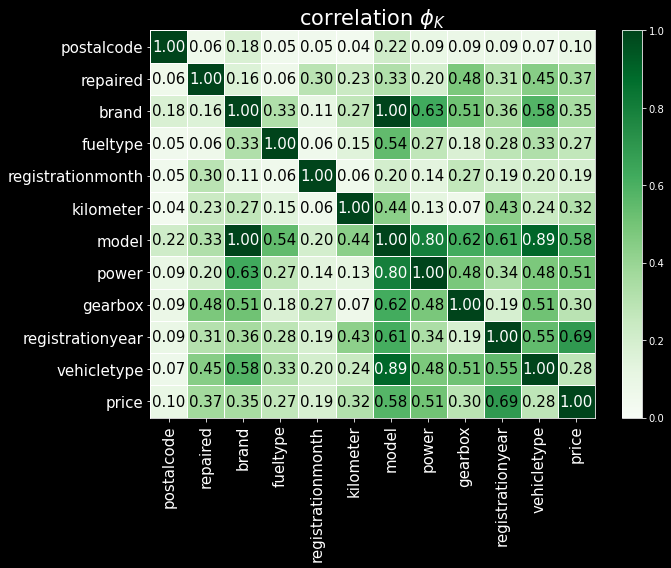

In [194]:
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(10, 8))
plt.tight_layout()

больше всего цена коррелирует с registrationyear, model, power и repaired. postcode слабо влияет на цену, поэтому от этой колонки лучше избавиться

In [195]:
df.drop(['postalcode'], axis=1, inplace=True)

In [196]:
df

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,repaired
0,480,unknown,1993,manual,104.772656,golf,150000,0,petrol,volkswagen,unknown
1,18300,coupe,2011,manual,190.000000,unknown,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163.000000,grand,125000,8,gasoline,jeep,unknown
3,1500,small,2001,manual,75.000000,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69.000000,fabia,90000,7,gasoline,skoda,no
...,...,...,...,...,...,...,...,...,...,...,...
354364,0,unknown,2005,manual,104.772656,colt,150000,7,petrol,mitsubishi,yes
354365,2200,unknown,2005,unknown,104.772656,unknown,20000,1,NaN,sonstige_autos,unknown
354366,1199,convertible,2000,auto,101.000000,fortwo,125000,3,petrol,smart,no
354367,9200,bus,1996,manual,102.000000,transporter,150000,3,gasoline,volkswagen,no


In [197]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 347354 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   price              347354 non-null  int64  
 1   vehicletype        347354 non-null  object 
 2   registrationyear   347354 non-null  int64  
 3   gearbox            347354 non-null  object 
 4   power              347354 non-null  float64
 5   model              347354 non-null  object 
 6   kilometer          347354 non-null  int64  
 7   registrationmonth  347354 non-null  int64  
 8   fueltype           315538 non-null  object 
 9   brand              347354 non-null  object 
 10  repaired           347354 non-null  object 
dtypes: float64(1), int64(4), object(6)
memory usage: 31.8+ MB


итоговые данные получились размера 347354 на 11, много категориальных признаков, более или менее вычистили все неиформативные признаки и аномалии в данных. 

# modeling

какие модели планируется использовать: 

1. ridge регрессия 
2. LightGBM
3. CatBoost 

In [198]:
original_df = df.copy() 

## ridge regression

### data prep 

вот тут надо кодировать все данные вроде уже ПОСЛЕ разления на тестовую и обучающую выборки

In [199]:
cat_features = df.select_dtypes(include='object').columns
print('категориальные фичи', list(cat_features))

display(df[cat_features].nunique().sort_values())

категориальные фичи ['vehicletype', 'gearbox', 'model', 'fueltype', 'brand', 'repaired']


gearbox          3
repaired         3
fueltype         7
vehicletype      9
brand           40
model          250
dtype: int64

если засовывать таким способом фичи в one hot encoder, то получатся лишние фичи: 

любая машина по сути это уникальное сочетение бренда + модели, чтобы не кодировать эти две взаимосвязаныые фичи, лучше создать дополнительную: auto_model. 

таким образом мы сможем значительно уменьшить время обучения модели (сложность регрессии ~np^2), а это является одним из важных компонентов для заказчика 

In [200]:
df['auto_model'] = df['brand'] + '_' + df['model'] 
df.drop(['brand', 'model'], axis=1, inplace=True)

In [201]:
cat_features = df.select_dtypes(include='object').columns
print('категориальные фичи', list(cat_features))

display(df[cat_features].nunique().sort_values())

категориальные фичи ['vehicletype', 'gearbox', 'fueltype', 'repaired', 'auto_model']


gearbox          3
repaired         3
fueltype         7
vehicletype      9
auto_model     336
dtype: int64

In [202]:
encoder = LabelEncoder() 
df['auto_model'] = encoder.fit_transform(df['auto_model'])

оставшиеся фичи можно закодировать OHE

In [203]:
cat_features = df.select_dtypes(include='object').columns
print('категориальные фичи', list(cat_features))

display(df[cat_features].nunique().sort_values())

категориальные фичи ['vehicletype', 'gearbox', 'fueltype', 'repaired']


gearbox        3
repaired       3
fueltype       7
vehicletype    9
dtype: int64

In [207]:
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)

encoder_ohe.fit(df[cat_features])

df[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(df[cat_features])

df = df.drop(cat_features, axis=1)

In [209]:
df

,price,registrationyear,power,kilometer,registrationmonth,auto_model,vehicletype_convertible,vehicletype_coupe,vehicletype_other,vehicletype_sedan,...,gearbox_unknown,fueltype_electric,fueltype_gasoline,fueltype_hybrid,fueltype_lpg,fueltype_other,fueltype_petrol,fueltype_nan,repaired_unknown,repaired_yes
0,480,1993,104.772656,150000,0,310,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,18300,2011,190.000000,125000,5,23,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,9800,2004,163.000000,125000,8,119,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1500,2001,75.000000,150000,6,310,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,3600,2008,69.000000,90000,7,267,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,0,2005,104.772656,150000,7,188,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
354365,2200,2005,104.772656,20000,1,279,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
354366,1199,2000,101.000000,125000,3,275,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
354367,9200,1996,102.000000,150000,3,323,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


итоговый датафрейм разроссся, но не критично, колонк стало 25

In [210]:
#подготовим выборки для обучения  
features = df.drop(['price'], axis=1)
target = df['price']

X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.25, random_state=RANDOM_STATE)

данные еще и получились разнокалиберные, поэтому лучше использовать Standart Scaler для их преобразования 

In [208]:
df

,price,registrationyear,power,kilometer,registrationmonth,auto_model,vehicletype_convertible,vehicletype_coupe,vehicletype_other,vehicletype_sedan,...,gearbox_unknown,fueltype_electric,fueltype_gasoline,fueltype_hybrid,fueltype_lpg,fueltype_other,fueltype_petrol,fueltype_nan,repaired_unknown,repaired_yes
0,480,1993,104.772656,150000,0,310,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,18300,2011,190.000000,125000,5,23,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,9800,2004,163.000000,125000,8,119,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1500,2001,75.000000,150000,6,310,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,3600,2008,69.000000,90000,7,267,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,0,2005,104.772656,150000,7,188,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
354365,2200,2005,104.772656,20000,1,279,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
354366,1199,2000,101.000000,125000,3,275,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
354367,9200,1996,102.000000,150000,3,323,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## ridge regression